In [6]:
!pip install fastapi
!pip install colabcode

  Obtaining dependency information for colabcode from https://files.pythonhosted.org/packages/4b/90/f635c37e8e87cb9df76873edd35068e7b10cd20ac0ba4d2392ae7f307fe9/colabcode-0.3.0-py3-none-any.whl.metadata
  Obtaining dependency information for pyngrok>=5.0.0 from https://files.pythonhosted.org/packages/cb/55/68b89d526e8331724665dcded0a32a76d73d6bcac41cc56084fda8e25486/pyngrok-7.1.6-py3-none-any.whl.metadata
  Obtaining dependency information for nest-asyncio==1.4.3 from https://files.pythonhosted.org/packages/5c/33/10805a3359f56ac4f3b520e64b9d5e6a288d87be95777b8023c64cba60f1/nest_asyncio-1.4.3-py3-none-any.whl.metadata
  Obtaining dependency information for uvicorn==0.13.1 from https://files.pythonhosted.org/packages/ef/67/546c35e9fffb585ea0608ba3bdcafe17ae402e304367203d0b08d6c23051/uvicorn-0.13.1-py3-none-any.whl.metadata
  Obtaining dependency information for jupyterlab==3.0.7 from https://files.pythonhosted.org/packages/90/27/149c258b8e80552ba1ad35636eca308776a284cb151cb8fcfff70adfbd0

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
black 0.0 requires click>=8.0.0, but you have click 7.1.2 which is incompatible.
conda-index 0.3.0 requires click>=8, but you have click 7.1.2 which is incompatible.
dask 2023.6.0 requires click>=8.0, but you have click 7.1.2 which is incompatible.
distributed 2023.6.0 requires click>=8.0, but you have click 7.1.2 which is incompatible.
fastapi-cli 0.0.3 requires uvicorn[standard]>=0.15.0, but you have uvicorn 0.13.1 which is incompatible.
flask 2.2.2 requires click>=8.0, but you have click 7.1.2 which is incompatible.
python-lsp-black 1.2.1 requires black>=22.3.0, but you have black 0.0 which is incompatible.
typer 0.12.3 requires click>=8.0.0, but you have click 7.1.2 which is incompatible.


In [16]:
from fastapi import FastAPI
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [17]:
BATCH_SIZE = 15
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=400

In [18]:

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Plantvillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 149 files belonging to 6 classes.


In [19]:
class_names = dataset.class_names
class_names

['A', 'B', 'C', 'D', 'E', 'K']

In [20]:
len(dataset)

10

In [21]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(15, 256, 256, 3)
[3 1 3 4 3 1 5 1 1 0 0 2 2 3 0]


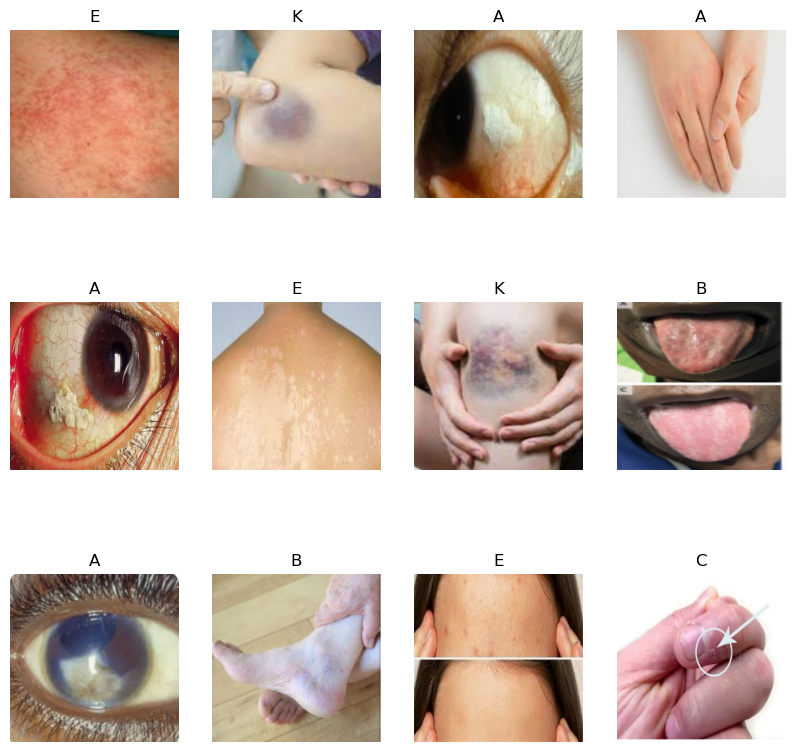

In [22]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)  # Change this line to (3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [23]:
len(dataset)

10

In [24]:
train_size = 0.8
len(dataset)*train_size

8.0

In [25]:
train_ds = dataset.take(8)
len(train_ds)

8

In [26]:


test_ds = dataset.skip(8)
len(test_ds)

2

In [27]:
val_size=0.1
len(dataset)*val_size

1.0

In [28]:
val_ds = test_ds.take(1)
len(val_ds)

1

In [29]:
test_ds = test_ds.skip(1)
len(test_ds)

1

In [30]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size + val_size)  # Modified this line
    
    return train_ds, val_ds, test_ds


In [31]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [32]:
len(train_ds)

8

In [33]:
len(val_ds)

1

In [34]:
len(test_ds)

1

In [35]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [36]:
resize_and_rescale = tf.keras.Sequential([
  tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  tf.keras.layers.Rescaling(1./255),
])


In [37]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.2),
])


In [38]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [39]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 6  # Change this to 6 since you have 6 classes

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),  # Adjusted output size
])

model.build(input_shape=input_shape)


C:\Users\Nayani Tharushika\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [40]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (15, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (15, 254, 254, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (15, 127, 127, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (15, 125, 125, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (15, 62, 62, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (15, 60, 60, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (15, 30, 30, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (15, 28, 28, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (15, 14, 14, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (15, 12, 12, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (15, 6, 6, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (15, 4, 4, 64)              │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (15, 2, 2, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (15, 256)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (15, 64)                    │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (15, 6)                     │             390 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 183,942 (718.52 KB)

 Trainable params: 183,942 (718.52 KB)

 Non-trainable params: 0 (0.00 B)

In [41]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [42]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=400,
)


Epoch 1/400
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 323ms/step - accuracy: 0.2271 - loss: 1.8020 - val_accuracy: 0.2000 - val_loss: 1.7846
Epoch 2/400
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 264ms/step - accuracy: 0.1667 - loss: 1.7924 - val_accuracy: 0.2667 - val_loss: 1.7896
Epoch 3/400
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 290ms/step - accuracy: 0.1879 - loss: 1.7905 - val_accuracy: 0.3333 - val_loss: 1.7869
Epoch 4/400
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 289ms/step - accuracy: 0.1893 - loss: 1.7883 - val_accuracy: 0.0000e+00 - val_loss: 1.7821
Epoch 5/400
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 287ms/step - accuracy: 0.1383 - loss: 1.7859 - val_accuracy: 0.0667 - val_loss: 1.7811
Epoch 6/400
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 264ms/step - accuracy: 0.2041 - loss: 1.7912 - val_accuracy: 0.0667 - val_loss: 1.7882
Epoch 7/400
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 263ms/step - accuracy: 0.2738 - loss: 1.7885 - val_accuracy: 0.0667 - val_loss: 1.7965
Epoch 8/400
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 266ms/step - accuracy: 0.2504 - loss: 1.7812 - val_accuracy: 0.0667

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 285ms/step - accuracy: 0.3303 - loss: 1.6931 - val_accuracy: 0.4667 - val_loss: 1.5813
Epoch 52/400
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 293ms/step - accuracy: 0.2730 - loss: 1.6220 - val_accuracy: 0.2000 - val_loss: 1.5940
Epoch 53/400
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 280ms/step - accuracy: 0.4057 - loss: 1.5356 - val_accuracy: 0.4667 - val_loss: 1.3495
Epoch 54/400
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 315ms/step - accuracy: 0.3620 - loss: 1.5314 - val_accuracy: 0.4000 - val_loss: 1.5146
Epoch 55/400
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 287ms/step - accuracy: 0.4194 - loss: 1.5819 - val_accuracy: 0.4667 - val_loss: 1.3271
Epoch 56/400
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 286ms/step - accuracy: 0.4449 - loss: 1.4522 - val_accuracy: 0.6000 - val_loss: 1.1822
Epoch 57/400
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 296ms/step - accuracy: 0.4307 - loss: 1.4681 - val_accuracy: 0.6667 - val_loss: 1.1603
Epoch 58/400
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 306ms/step - accuracy: 0.5115 - loss: 1.3544 - val_accuracy: 0.6667 - val_lo

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 282ms/step - accuracy: 0.5564 - loss: 1.0457 - val_accuracy: 0.7333 - val_loss: 0.8148
Epoch 102/400
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 287ms/step - accuracy: 0.6267 - loss: 0.8778 - val_accuracy: 0.8000 - val_loss: 0.7172
Epoch 103/400
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 278ms/step - accuracy: 0.6039 - loss: 0.9805 - val_accuracy: 0.8667 - val_loss: 0.8041
Epoch 104/400
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 272ms/step - accuracy: 0.7100 - loss: 0.9077 - val_accuracy: 0.6000 - val_loss: 0.9937
Epoch 105/400
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 281ms/step - accuracy: 0.6231 - loss: 0.9198 - val_accuracy: 0.8000 - val_loss: 0.8260
Epoch 106/400
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 270ms/step - accuracy: 0.6705 - loss: 0.8636 - val_accuracy: 0.8000 - val_loss: 0.8051
Epoch 107/400
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 276ms/step - accuracy: 0.7129 - loss: 0.8772 - val_accuracy: 0.7333 - val_loss: 0.9047
Epoch 108/400
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 277ms/step - accuracy: 0.6985 - loss: 0.7973 - val_accuracy: 0.5333 -

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 275ms/step - accuracy: 0.7876 - loss: 0.5699 - val_accuracy: 0.8667 - val_loss: 0.6265
Epoch 152/400
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 285ms/step - accuracy: 0.8053 - loss: 0.6268 - val_accuracy: 0.7333 - val_loss: 0.6679
Epoch 153/400
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 289ms/step - accuracy: 0.7595 - loss: 0.6594 - val_accuracy: 0.8000 - val_loss: 0.7345
Epoch 154/400
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 283ms/step - accuracy: 0.8384 - loss: 0.5200 - val_accuracy: 0.8000 - val_loss: 0.6821
Epoch 155/400
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 284ms/step - accuracy: 0.7614 - loss: 0.6122 - val_accuracy: 0.8000 - val_loss: 0.8359
Epoch 156/400
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 282ms/step - accuracy: 0.7894 - loss: 0.5233 - val_accuracy: 0.8667 - val_loss: 0.5709
Epoch 157/400
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 274ms/step - accuracy: 0.8127 - loss: 0.4970 - val_accuracy: 0.7333 - val_loss: 1.0638
Epoch 158/400
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 280ms/step - accuracy: 0.8054 - loss: 0.5763 - val_accuracy: 0.8000 -

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 270ms/step - accuracy: 0.8777 - loss: 0.3796 - val_accuracy: 0.8000 - val_loss: 0.5298
Epoch 202/400
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 280ms/step - accuracy: 0.7943 - loss: 0.4372 - val_accuracy: 0.8000 - val_loss: 0.5114
Epoch 203/400
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 272ms/step - accuracy: 0.8453 - loss: 0.4115 - val_accuracy: 0.9333 - val_loss: 0.4011
Epoch 204/400
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 293ms/step - accuracy: 0.8821 - loss: 0.4411 - val_accuracy: 0.9333 - val_loss: 0.3644
Epoch 205/400
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 278ms/step - accuracy: 0.8866 - loss: 0.3012 - val_accuracy: 0.8000 - val_loss: 0.4444
Epoch 206/400
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 295ms/step - accuracy: 0.8477 - loss: 0.4552 - val_accuracy: 0.8667 - val_loss: 0.5059
Epoch 207/400
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 276ms/step - accuracy: 0.9002 - loss: 0.3722 - val_accuracy: 0.8667 - val_loss: 0.4508
Epoch 208/400
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 267ms/step - accuracy: 0.9594 - loss: 0.2455 - val_accuracy: 0.8667 -

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 273ms/step - accuracy: 0.9330 - loss: 0.1965 - val_accuracy: 0.8667 - val_loss: 0.6495
Epoch 252/400
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 290ms/step - accuracy: 0.9557 - loss: 0.1516 - val_accuracy: 0.8667 - val_loss: 0.6853
Epoch 253/400
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 285ms/step - accuracy: 0.9114 - loss: 0.2325 - val_accuracy: 0.8667 - val_loss: 0.6942
Epoch 254/400
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 287ms/step - accuracy: 0.9565 - loss: 0.1705 - val_accuracy: 0.8000 - val_loss: 0.6933
Epoch 255/400
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 282ms/step - accuracy: 0.9349 - loss: 0.1451 - val_accuracy: 0.8667 - val_loss: 0.6055
Epoch 256/400
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 279ms/step - accuracy: 0.9425 - loss: 0.2110 - val_accuracy: 0.8667 - val_loss: 0.6022
Epoch 257/400
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 285ms/step - accuracy: 0.9059 - loss: 0.2209 - val_accuracy: 0.8667 - val_loss: 0.6431
Epoch 258/400
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 269ms/step - accuracy: 0.9262 - loss: 0.1808 - val_accuracy: 0.8000 -

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 330ms/step - accuracy: 0.9901 - loss: 0.0436 - val_accuracy: 0.9333 - val_loss: 0.0845
Epoch 302/400
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 284ms/step - accuracy: 0.9822 - loss: 0.0931 - val_accuracy: 0.9333 - val_loss: 0.1038
Epoch 303/400
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 288ms/step - accuracy: 0.9942 - loss: 0.0534 - val_accuracy: 0.9333 - val_loss: 0.1827
Epoch 304/400
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 278ms/step - accuracy: 0.9634 - loss: 0.1563 - val_accuracy: 0.9333 - val_loss: 0.1373
Epoch 305/400
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 300ms/step - accuracy: 0.9760 - loss: 0.0645 - val_accuracy: 0.9333 - val_loss: 0.0763
Epoch 306/400
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 488ms/step - accuracy: 0.9811 - loss: 0.0693 - val_accuracy: 1.0000 - val_loss: 0.0768
Epoch 307/400
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 514ms/step - accuracy: 0.9685 - loss: 0.0504 - val_accuracy: 0.8667 - val_loss: 0.3801
Epoch 308/400
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 281ms/step - accuracy: 1.0000 - loss: 0.0430 - val_accuracy: 0.9333 -

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 283ms/step - accuracy: 0.9156 - loss: 0.2996 - val_accuracy: 0.9333 - val_loss: 0.2573
Epoch 352/400
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 280ms/step - accuracy: 0.9506 - loss: 0.1849 - val_accuracy: 0.8667 - val_loss: 0.2559
Epoch 353/400
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 291ms/step - accuracy: 0.8835 - loss: 0.2947 - val_accuracy: 1.0000 - val_loss: 0.0773
Epoch 354/400
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 313ms/step - accuracy: 0.8418 - loss: 0.8669 - val_accuracy: 0.8000 - val_loss: 0.4345
Epoch 355/400
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 316ms/step - accuracy: 0.9254 - loss: 0.3728 - val_accuracy: 0.8000 - val_loss: 0.3113
Epoch 356/400
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 306ms/step - accuracy: 0.8457 - loss: 0.4353 - val_accuracy: 0.8667 - val_loss: 0.6663
Epoch 357/400
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 382ms/step - accuracy: 0.8871 - loss: 0.4730 - val_accuracy: 0.8667 - val_loss: 0.2907
Epoch 358/400
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 330ms/step - accuracy: 0.8583 - loss: 0.3610 - val_accuracy: 0.6000 -

In [43]:
scores = model.evaluate(test_ds)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.7333 - loss: 1.4631


In [44]:
scores

[1.463060736656189, 0.7333333492279053]

In [45]:
history

In [46]:
history.params

{'verbose': 1, 'epochs': 400, 'steps': 8}

In [47]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [48]:
type(history.history['loss'])

list

In [49]:
len(history.history['loss'])

400

In [50]:
history.history['loss'][:5]

[1.8007125854492188,
 1.7927143573760986,
 1.790887475013733,
 1.7895978689193726,
 1.788577914237976]

In [51]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

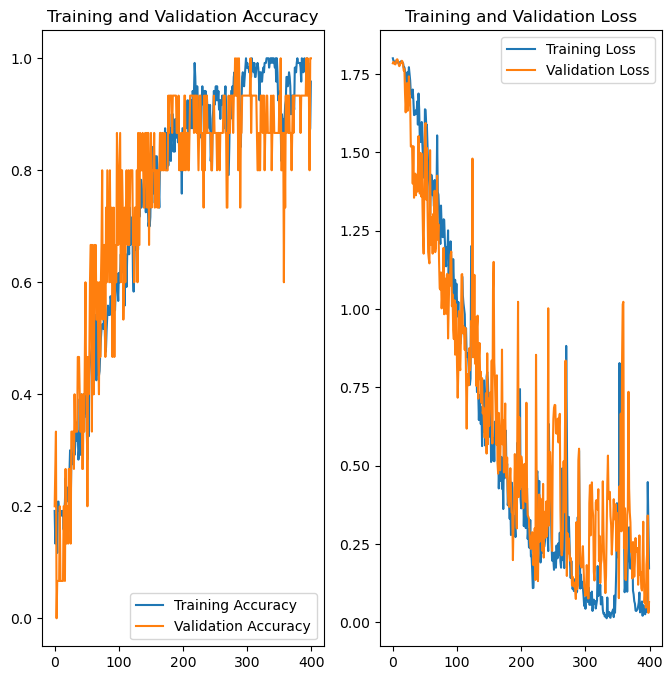

In [52]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: E
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step
predicted label: E


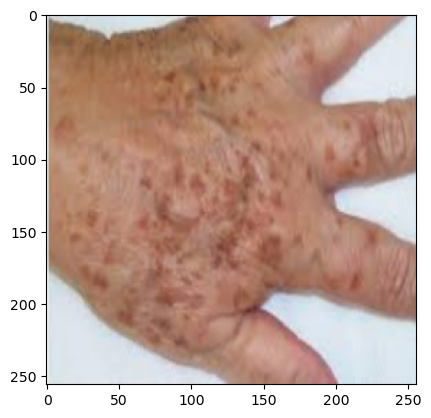

In [53]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [54]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


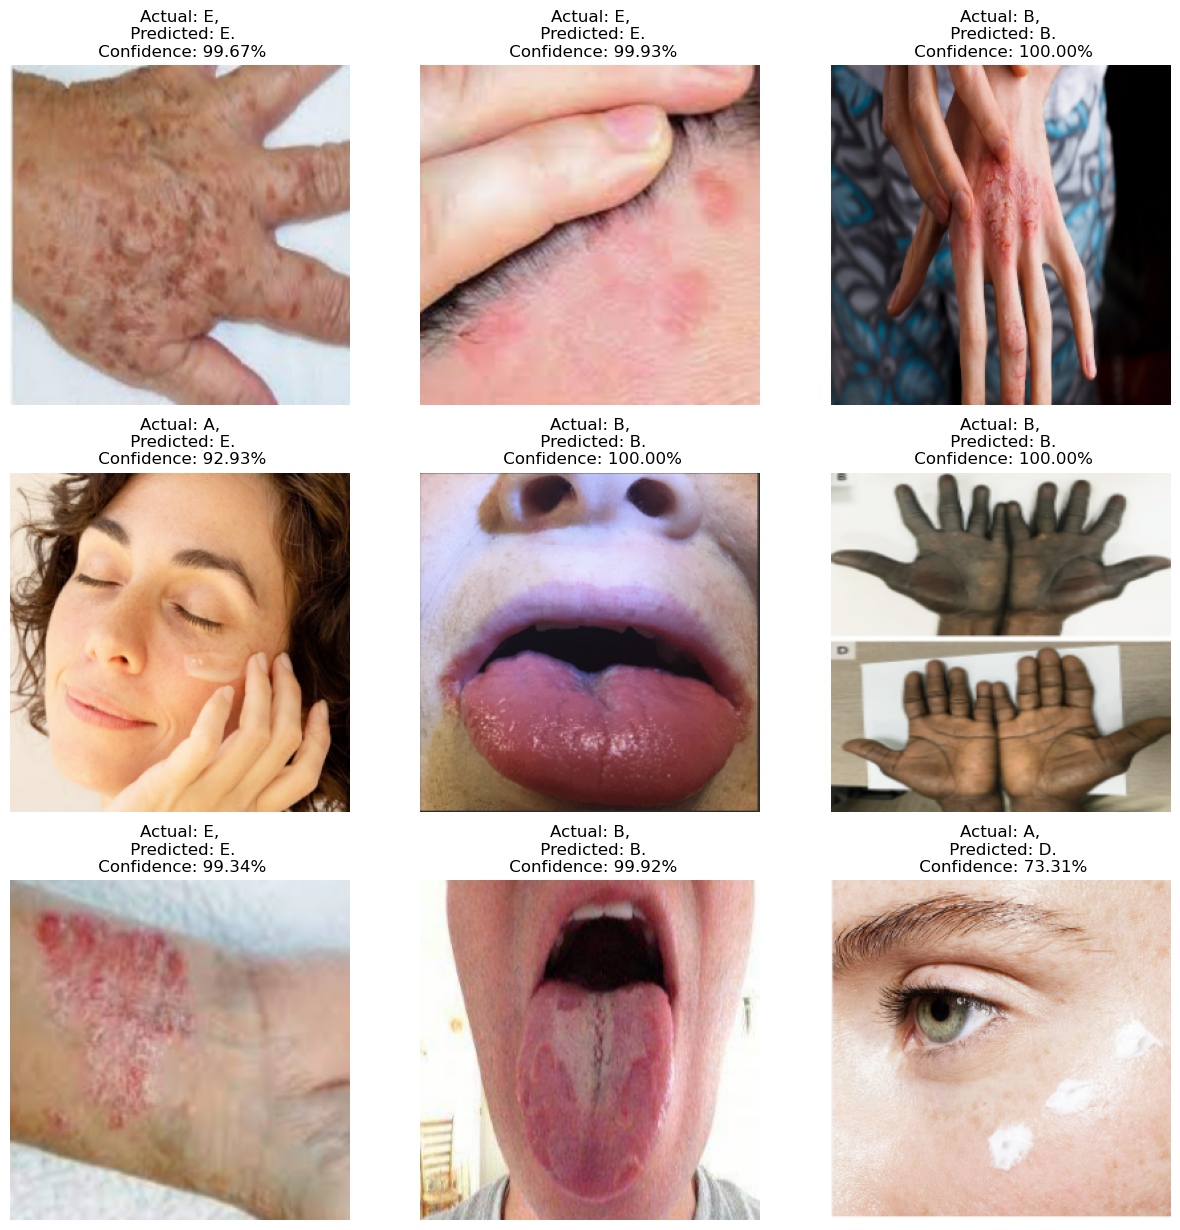

In [55]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())  # Assuming you have a predict function
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence:.2f}%")  # Adjusted formatting
        
        plt.axis("off")

In [58]:
import os

# Extract numeric parts from filenames and convert to integers
existing_versions = [int(filename.split('.')[0]) for filename in os.listdir("../models") if filename.endswith('.keras')]

# Get the maximum existing version or default to 0 if no models exist
model_version = max(existing_versions, default=0) + 1

# Save the model with the next version number
model.save(f"../models/{model_version}.h5")


FileNotFoundError: [WinError 3] The system cannot find the path specified: '../models'